In [1]:
# https://towardsdatascience.com/find-and-plot-your-optimal-path-using-plotly-and-networkx-in-python-17e75387b873
import osmnx as ox
import networkx as nx
import plotly.graph_objects as go
import numpy as np
import pickle
import os

import plotly.express as px

import geopandas as gpd ## geopandas gdal 
import fiona

from shapely.ops import nearest_points

In [6]:
# Opening path, streelamps & CCTV
fname = '../data/SingaporeStreets.zip'
SLC = gpd.read_file(fname)
SLC

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,...,Lamps25m,Lamps10m,CCTV100mRE,CCTV50mRE,CCTV25mRE,Length,Trees50m,Trees25m,Trees10m,geometry
0,1,5115,tertiary,Keng Lee Road,None,F,50,0,F,F,...,6,4,0,0,0,100.099656,120,89,50,"LINESTRING (103.84379 1.31370, 103.84468 1.31383)"
1,2,5115,tertiary,Keng Lee Road,None,F,50,0,F,F,...,4,2,0,0,0,38.075346,51,29,18,"LINESTRING (103.84468 1.31383, 103.84495 1.313..."
2,3,5153,footway,None,None,B,0,0,F,F,...,1,0,0,0,0,99.549892,36,12,6,"LINESTRING (103.84083 1.31463, 103.84115 1.31379)"
3,4,5153,footway,None,None,B,0,0,F,F,...,2,0,0,0,0,47.704451,57,19,7,"LINESTRING (103.84115 1.31379, 103.84126 1.313..."
4,5,5122,residential,Sarkies Road,None,B,50,0,F,F,...,4,1,0,0,0,21.937559,46,17,1,"LINESTRING (103.83721 1.31461, 103.83727 1.314..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50343,50344,5153,footway,None,None,B,0,0,F,F,...,2,1,0,0,0,100.068655,42,24,10,"LINESTRING (103.84753 1.29756, 103.84767 1.297..."
50344,50345,5153,footway,None,None,B,0,0,F,F,...,0,0,0,0,0,36.577630,109,5,1,"LINESTRING (103.84720 1.29759, 103.84721 1.297..."
50345,50346,5153,footway,None,None,B,0,0,F,F,...,0,0,0,0,0,6.727414,104,4,2,"LINESTRING (103.84721 1.29759, 103.84721 1.297..."
50346,50347,5153,footway,None,None,B,0,0,F,F,...,0,0,0,0,0,3.673968,92,5,1,"LINESTRING (103.84721 1.29753, 103.84720 1.29750)"


In [36]:
def loadShp():
    G= nx.readwrite.nx_shp.read_shp('../streamlit_app/data/s3/StreetsLampsCCTVTrees.shp')
    return G

# Loading the loaded shapefile
G = loadShp()

## Adding weights
weighted_G = nx.Graph()
for data in G.edges(data=True):
    weighted_G.add_edge(data[0],data[1],weight=data[2]['Length'])
pos = {v:v for v in weighted_G.nodes()}
labels = nx.get_edge_attributes(weighted_G,'weight')

In [37]:
SLC.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

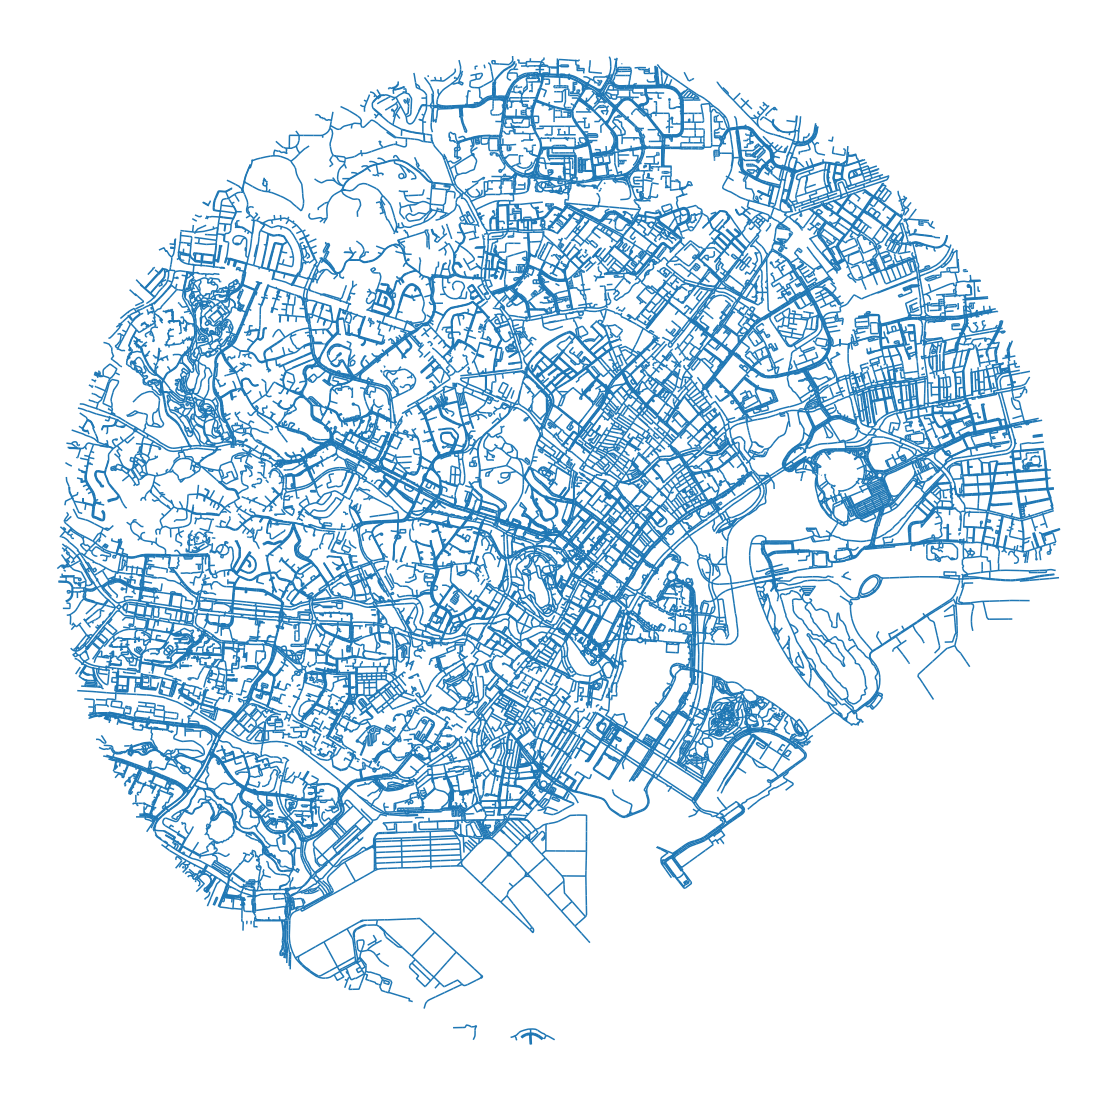

In [38]:
ax = ox.project_gdf(SLC).plot(figsize=(20,20)) 
_ = ax.axis('off')

In [46]:
xmin, ymin, xmax, ymax = SLC.total_bounds
xmin, ymin, xmax, ymax


(103.80277007767799, 1.2517386, 103.8944071, 1.3426393)

# Getting trees

In [56]:
cctv= gpd.read_file('../data/lta-road-camera-shp.zip') 
cctv = cctv.to_crs("EPSG:4326")
cctv = cctv.cx[xmin:xmax, ymin:ymax]

In [57]:
cctv.to_file("../data/sCCTV")

In [58]:
gTrees = gpd.read_file('../data/sTrees.zip') 
gLamps = gpd.read_file('../data/sTrees.zip') 
gPark = gpd.read_file('../data/sTrees.zip') 
gCCTV = gpd.read_file('../data/sCCTV.zip') 

In [42]:
gTrees

,tree_id,species_id,height_est,age,flowering,heritage,geometry
0,10002222,1602,12,16.0,0,0,POINT (103.81867 1.26622)
1,10002223,1602,9,16.0,0,0,POINT (103.82051 1.26546)
2,10002224,1602,12,16.0,0,0,POINT (103.82042 1.26549)
3,10002225,1602,6,16.0,0,0,POINT (103.82056 1.26542)
4,10002226,1602,12,16.0,0,0,POINT (103.82007 1.26551)
...,...,...,...,...,...,...,...
123450,10686229,1756,9,1.0,0,0,POINT (103.81508 1.32263)
123451,10686230,29350,24,1.0,0,0,POINT (103.81306 1.31014)
123452,10686231,1756,6,1.0,0,0,POINT (103.81487 1.32244)
123453,10686232,1660,9,1.0,0,0,POINT (103.81498 1.32254)


#### Making sure we only have so many trees

<AxesSubplot:>

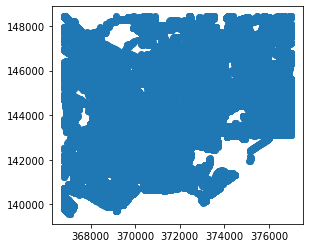

In [12]:
ox.project_gdf(tdf_simple).plot()

# Mapping other layers

### Opening park facilities

In [28]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
gdf = gpd.read_file('../data/park-facilities/park-facilities-kml.kml', driver='KML')
gdf['lon'] = gdf['geometry'].x
gdf['lat'] = gdf['geometry'].y

In [29]:
gdf.cx[xmin:xmax, ymin:ymax]
gdf[["Description","geometry"]].to_file("../data/sParks") 
gdf

<ipython-input-29-07b3bc6c7d49>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf[["Description","geometry"]].to_file("../data/sParks")


,Name,Description,geometry,lon,lat
0,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.77146 1.44884 0.00000),103.771464,1.448836
1,kml_2,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.77885 1.45243 0.00000),103.778850,1.452432
2,kml_3,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.77764 1.45401 0.00000),103.777642,1.454011
3,kml_4,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.77878 1.45232 0.00000),103.778780,1.452315
4,kml_5,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.77380 1.45037 0.00000),103.773795,1.450367
...,...,...,...,...,...
2164,kml_2165,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.81537 1.31131 0.00000),103.815371,1.311306
2165,kml_2166,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.81643 1.32083 0.00000),103.816425,1.320825
2166,kml_2167,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.81659 1.31717 0.00000),103.816587,1.317171
2167,kml_2168,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.81516 1.32048 0.00000),103.815159,1.320484


### Opening lamps

In [31]:
# Opening lamps facilities

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
gdfL = gpd.read_file('../data/tooBig/lta-lamp-post/lta-lamp-post-kml.kml', driver='KML') 
print(len(gdfL))
gdfL.head(3)

119834


,Name,Description,geometry
0,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.78611 1.33499 0.00000)
1,kml_2,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.78651 1.33485 0.00000)
2,kml_3,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.78686 1.33473 0.00000)


In [34]:
gdfL = gdfL.cx[xmin:xmax, ymin:ymax]
gdfL[["Name","geometry"]].to_file("../data/sLamps") 
print(len(gdfL))
gdfL.head(3)

27992


,Name,Description,geometry
41,kml_42,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.84678 1.30439 0.00000)
42,kml_43,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.84691 1.30429 0.00000)
43,kml_44,<center><table><tr><th colspan='2' align='cent...,POINT Z (103.84705 1.30419 0.00000)


# Representing paths

In [38]:
def plot_path(lat, long, origin_point, destination_point):
    
    """
    Given a list of latitudes and longitudes, origin 
    and destination point, plots a path on a map
    
    Parameters
    ----------
    lat, long: list of latitudes and longitudes
    origin_point, destination_point: co-ordinates of origin
    and destination
    Returns
    -------
    Nothing. Only shows the map.
    """
    

    #fig = px.scatter_geo(gdf, locations="geometry" )

    # adding the lines joining the nodes
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'blue')))
    
        # adding the lines joining the nodes
        
    fig.add_trace(go.Scattermapbox(
        name = "Parcs",
        mode = "markers",
        lon = gdf.lon,
        lat = gdf.lat,
        marker = {'size': 12, 'color':"blue"}))
    
    
    # adding source marker
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
     
    # adding destination marker
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    
    # getting center for plots:
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    # defining the layout using mapbox_style
    fig.update_layout(mapbox_style="open-street-map",#stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 15})
    fig.show()

In [107]:
def getNetworkAround(lat,lon,distm):
    fn = '../data/osmnx/'+str(lat)+"_"+str(lon)+"_"+str(distm)+'.pickle'
    if not os.path.isfile(fn):
        G = ox.graph_from_point((lat, lon), dist=distm, network_type='all_private') #walk
        with open(fn, 'wb') as f:
            pickle.dump(G, f)
    else:
        with open(fn,"rb") as f:
            G = pickle.load(f)
    return G

In [4]:
# Defining the map boundaries 
def showSGP():
    north, east, south, west = 1.327587854836542, 103.88297275579747, 1.2669696458157633, 103.79947552605792
    # Downloading the map as a graph object 
    G = ox.graph_from_bbox(north, south, east, west, network_type = 'walk',clean_periphery=False)  
    # Plotting the map graph 
    ox.plot_graph(G)

# Plotting the shortest path

In [108]:
def mapPath(G,origin_point,destination_point,WGT = 'length'):
    # define origin and desination locations 
    #origin_point = (1.278353050783832, 103.84105995326672) 
    #destination_point = (1.2853283229119088, 103.85262989657622)
    # get the nearest nodes to the locations 
    origin_node = ox.distance.nearest_nodes(G, origin_point[1],origin_point[0]) 
    destination_node = ox.distance.nearest_nodes(G, destination_point[1],destination_point[0])
    # printing the closest node id to origin and destination points origin_node, destination_node
    
        # Finding the optimal path 
    route = nx.shortest_path(G, origin_node, destination_node, weight = WGT) 
    # getting coordinates of the nodes
    # we will store the longitudes and latitudes in following list 
    long = [] 
    lat = []  
    for i in route:
        point = G.nodes[i]
        long.append(point['x'])
        lat.append(point['y'])
    plot_path(lat, long, origin_point, destination_point)
    route_map = ox.plot_route_folium(G, route)
    route_map.save('../data/osmnx/test.html')

# Custom edges values 

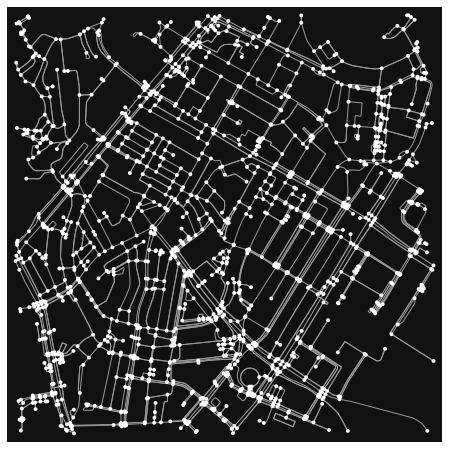

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [109]:
G = getNetworkAround(1.2806, 103.8464, 751)
ox.plot_graph(G)

In [112]:
for u,v,d in G.edges(data=True):
    #ID = d["osmid"]
    d['weight'] = 10 +  1.0 / d['length'] # + d['Lamps50m'] + d["CCTV100mRE"]

In [113]:
origin_point = (1.2822526633223938, 103.84732075349544) 
destination_point = (1.2785088771898996, 103.8413733342337)

mapPath(G,origin_point,destination_point,WGT = 'length')

In [123]:
origin_point = (1.2822526633223938, 103.84732075349544) 
destination_point = (1.2785088771898996, 103.8413733342337)

mapPath(G,origin_point,destination_point,WGT = 'weight')

KeyError: 'crs'

# Ideas for the formula

* Raw data
  * Count of CCTV nearby
  * Count of trees
  * Count of lamppost

* Attribute of the path (footway, steps, )
  * ! Steps can be an __accessibility__ issue -> delete, to sumplify the dataset
  * Tunnels -- feature to mark safety
  
* During night (and park paths could be closed)
  * Impact of lampost can be increased 
  * Parks

* Basemap with 3D buildings: 
  * https://maps-cdn.salesboard.biz/styles/klokantech-3d-gl-style/#14.86/1.2776/103.8476
  * https://docs.mapbox.com/mapbox-gl-js/example/3d-buildings/
  
* https://www.researchgate.net/publication/273472339_The_Digital_Life_of_Walkable_Streets